In [1]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import seaborn as sns

md2.visualization.set_perturbation_color('gray')
cols = [cm.tab10(i) for i in range(10)]
cols.append(cm.Set2(5))
cols.append(cm.Paired(4))

[DEBUG] Using default logger (stdout, stderr).


# McNulty et al., 2013 
# LF/HPP ==> HF/HS ==> LF/HPP

In [4]:
# Define the input directory
input_dir = Path('mcnulty-datasets/LF0')
# Define the output directory
output_dir = Path('mcnulty-results/LF0')
output_dir.mkdir(parents=True, exist_ok=True)

## Create MDSINE2 Study object from input datasets

In [5]:
# Parse tables of samples and cast in Subject sets. Automatically creates the subject classes with the respective names. {dataset.py, pylab/base.py}
mcnulty_lf0 = md2.dataset.parse(                                # Parse a dataset. Acts as a wrapper for mdsine2.Study.parse
    name='mcnulty_lf0',                                         # Name of the dataset
    metadata=str(input_dir / 'metadata.tsv'),                   # Metadata file
    taxonomy=str(input_dir / 'taxonomy.tsv'),                   # Taxonomy file
    reads=str(input_dir / 'reads.tsv'),                         # Reads file
    qpcr=str(input_dir / 'dna_yields.tsv'),                     # qPCR (DNA yields) file
    perturbations=str(input_dir / 'perturbations.tsv'),         # Perturbations file 
    sep='\t'                                                    # Separator used in the input files
)

[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations


## Visualize abundance over time and perturbation recurrence

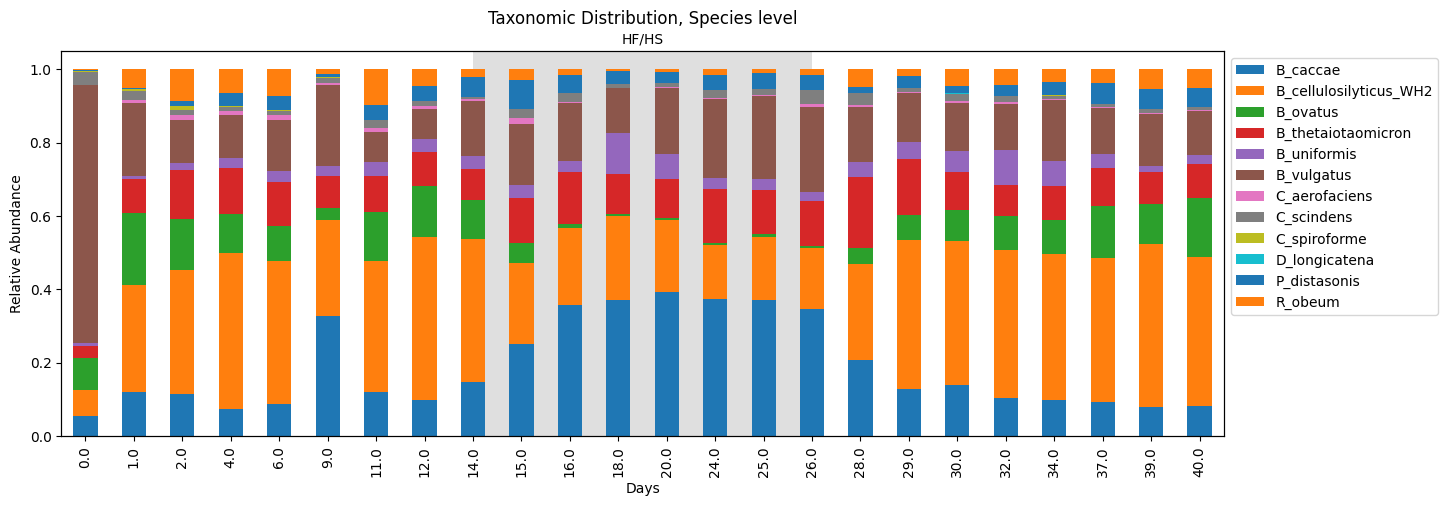

In [6]:
# Plot the taxa abundances at the species level for subject `1` {visualization.py}
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
md2.visualization.taxonomic_distribution_over_time(         # Produces a taxonomic bar graph for each datapoint
    mcnulty_lf0['1'],                                       # Subject we are getting the data from
    taxlevel='species',                                     # This is the taxonomic level to aggregate the data at
    label_formatter='%(name)s',                             # If specified, it will tell how to make the legend using the taxaname_formatter
    ax=ax                                                   # Axis to plot on
)
plt.show()

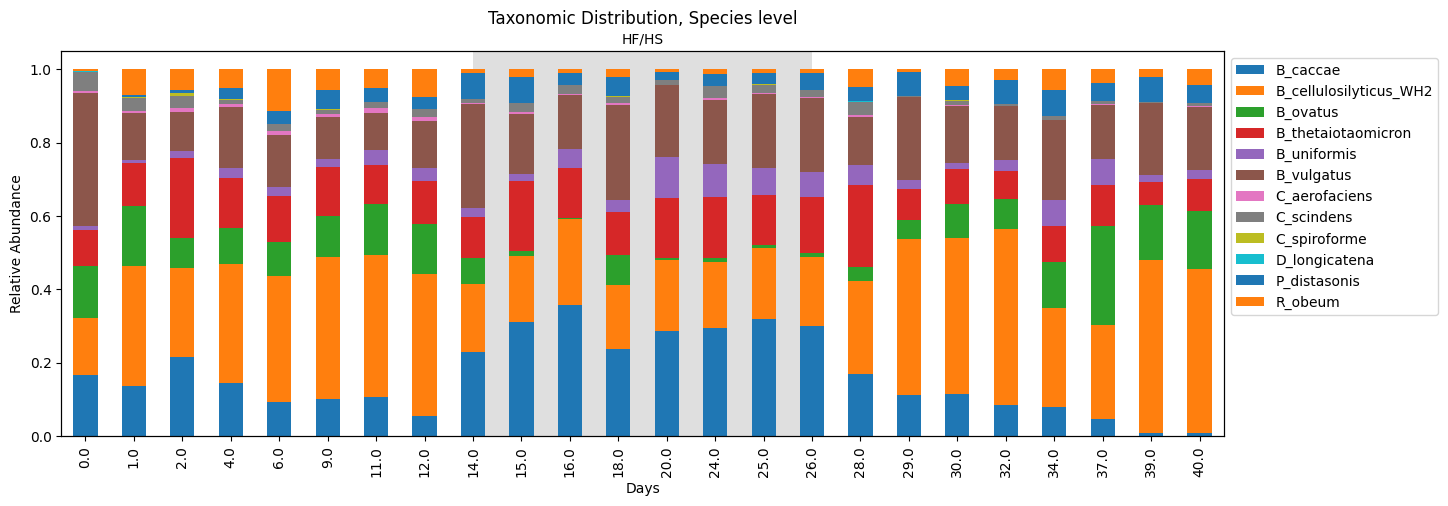

In [7]:
# Plot the taxa abundances at the species level for subject `7` {visualization.py}
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
md2.visualization.taxonomic_distribution_over_time(
    mcnulty_lf0['7'],                              
    taxlevel='species',                            
    label_formatter='%(name)s',                    
    ax=ax                                          
)
plt.show()

## Learning the Negative Binomial dispersion parameters

Before running the main inference loop we learn the negative binomial parameters ($d_0$, $d_1$) from our physical replicates

In [8]:
# Set negative binomial model inference parameters
# Configuration class for learning the negative binomial dispersion parameters. Note that these parameters are learned offline. {config.py}
params_lf0 = md2.config.NegBinConfig(       # Initialize the MCMC chain (NegBinConfig class)
    seed=0,                                 # Seed to start the inference
    burnin=100,                             # Number of initial Gibbs steps to throw away (burn-in iterations)
    n_samples=1000,                         # Number of total Gibbs steps (total iterations)
    checkpoint=100,                         # How often to write the trace in RAM to disk. Note that this must be a multiple of both burnin and n_samples
    basepath=str(output_dir / "negbin")     # Basepath to save the trace to disk
)

In [9]:
# Build the compute graph for learning the model that is used to learn negative binomial parameters {negbin.py}
mcmc_negbin_lf0 = md2.negbin.build_graph(       # Builds the graph used for posterior inference of the negative binomial dispersion parameters (mdsin2.BaseMCMC)
    params=params_lf0,                          # Parameters to run the model
    graph_name=mcnulty_lf0.name,                # Name (label) of the graph
    subjset=mcnulty_lf0                         # Subject (MDSINE2.Study object)
)

[DEBUG] Available subjects: 1,2,3,4,5,6,7
[DEBUG] Subject 1, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 2, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 3, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 4, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 5, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 6, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,12.0,14.0,15.0,16.0,18.0,20.0,24.0,25.0,26.0,28.0,29.0,30.0,32.0,34.0,37.0,39.0,40.0
[DEBUG] Subject 7, available qpcr: 0.0,1.0,2.0,4.0,6.0,9.0,11.0,

In [10]:
# Run inference to learn the negative binomial parameters {negbin.py, run.py, pylab/inferenec.py}
mcmc_negbin_lf0 = md2.negbin.run_graph(     # Run the MCMC chain mcmc (mdsin2.BaseMCMC)
    mcmc_negbin_lf0,                        # Inference object that is already built and initialized (mdsine2.BaseMCMC)
    crash_if_error=True)                    # If True, throws an error if there is an exception during inference.

 10%|▉         | 98/1000 [00:01<00:13, 67.19it/s][DEBUG] Inference iteration 100/1000, time: 1.7593419551849365
[DEBUG] Negative binomial dispersion a0: Value: 1.9465546447209898e-10, Acceptance rate: 1.0
[DEBUG] Negative binomial dispersion a1: Value: 0.5008475442330831, Acceptance rate: 0.46
[DEBUG] Filtering: no-mp : Time: 0.0176, Acc: [0.417, 0.333, 0.333, 0.333, 0.333, 0.250, 0.417], data/sec: 4769.09
 20%|█▉        | 197/1000 [00:03<00:12, 65.79it/s][DEBUG] Inference iteration 200/1000, time: 1.5533878803253174
[DEBUG] Negative binomial dispersion a0: Value: 1.3460452585217842e-10, Acceptance rate: 1.0
[DEBUG] Negative binomial dispersion a1: Value: 0.64404365705479, Acceptance rate: 0.8
[DEBUG] Filtering: no-mp : Time: 0.0134, Acc: [0.667, 0.667, 0.583, 0.250, 0.500, 0.333, 0.500], data/sec: 6263.94
 30%|██▉       | 299/1000 [00:04<00:10, 64.42it/s][DEBUG] Inference iteration 300/1000, time: 1.54994535446167
[DEBUG] Negative binomial dispersion a0: Value: 2.5098817139196567e-10,

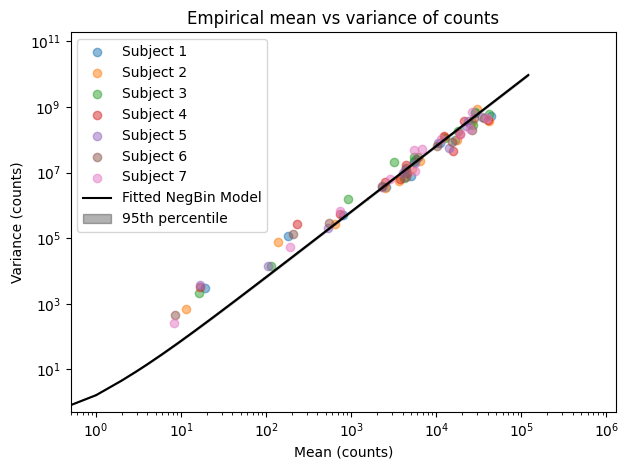

In [11]:
# Visualize the negative binomial dispersion model {negbin.py, visualization.py}
fig = md2.negbin.visualize_learned_negative_binomial_model(
    mcmc_negbin_lf0                         # Inference object with the negative binomial posteriors and the data it was learned on (mdsine2.BaseMCMC) 
)
fig.tight_layout()
plt.show()

In [12]:
# Summary of d0 and d1 posterior
print('a0', md2.summary(mcmc_negbin_lf0.graph[STRNAMES.NEGBIN_A0])) # d0
print('a1', md2.summary(mcmc_negbin_lf0.graph[STRNAMES.NEGBIN_A1])) # d1

a0 {'median': 1.2393166297743567e-10, 'mean': 1.3628458006955444e-10, '25th percentile': 7.992260196202748e-11, '75th percentile': 1.9706061755274507e-10}
a1 {'median': 0.6440948351455769, 'mean': 0.6417000832583004, '25th percentile': 0.6293286312851858, '75th percentile': 0.6593384564511456}


## Run inference on the full model

In [13]:
# Get a0 and a1 from negbin (get the mean of the posterior) and fixes them for inference {negbin.py, config.py, pylab/variables.py}
a0_lf0 = md2.summary(mcmc_negbin_lf0.graph[STRNAMES.NEGBIN_A0])['mean']
a1_lf0 = md2.summary(mcmc_negbin_lf0.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0_lf0)
print('negbin a1', a1_lf0)

negbin a0 1.3628458006955444e-10
negbin a1 0.6417000832583004


### Set por running inference with with SEED=0

In [14]:
# Set directory
basepath_s0 = output_dir / "mdsine2" / "seed0"
growth_rate_s0_dir = basepath_s0 / "growth-rate"
self_interactions_s0_dir = basepath_s0 / "self-interactions"
interactions_s0_dir = basepath_s0 / "interactions"
perturbation_s0_dir = basepath_s0 / "perturbation"
basepath_s0.mkdir(exist_ok=True, parents=True)
growth_rate_s0_dir.mkdir(exist_ok=True, parents=True)
self_interactions_s0_dir.mkdir(exist_ok=True, parents=True)
interactions_s0_dir.mkdir(exist_ok=True, parents=True)
perturbation_s0_dir.mkdir(exist_ok=True, parents=True)

In [15]:
# Initialize parameters of the model
params_lf0_s0 = md2.config.MDSINE2ModelConfig(
    basepath=str(basepath_s0),                  # Basepath to save the inference trace to disk
    seed=0,                                     # Seed to start the inference
    burnin=100,                                 # Number of initial Gibbs steps to throw away (burn-in iterations)
    n_samples=1000,                             # Number of total Gibbs steps (total iterations)
    negbin_a0=a0_lf0, negbin_a1=a1_lf0,         # Negative binomial dispersion parameters   
    checkpoint=100                              # How often to write the trace in RAM to disk. Note that this must be a multiple of both burnin and n_samples
)

In [16]:
# Initialize the clustering choice {config.py, pylab/variables.py}
params_lf0_s0.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
# Other options: 'spearman', , 'no-clusters', 'fixed-clustering', 'manual', 'random', 'taxonomy'

In [17]:
# Builds the graph with the posterior classes and creates an mdsine2.BaseMCMC inference chain object that you ran run inference with {run.py}
mcmc_lf0_s0 = md2.initialize_graph(         # Return pylab.inference.BaseMCMC
    params=params_lf0_s0,                   # Parameters to run the model (MDSINE2ModelConfig class)
    graph_name=mcnulty_lf0.name,            # Name (label) of the graph
    subjset=mcnulty_lf0                     # Subject (MDSINE2.Study object)
)

[INFO] max_value found: 1304402561.1345034, scaling_factor: 7.666344959720491e-08
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 7.6663E-08
[INFO] There are 168 qPCR measurements for 3 buckets. Each bucket is 56 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.  1.  2.  4.  6.  9. 11. 12. 14. 15. 16. 18. 20. 24. 25. 26. 28. 29.
 30. 32. 34. 37. 39. 40.]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 12
Cluster 100112
	members: ['B_caccae']
	size: 1
Cluster 100113
	members: ['B_cellulosilyticus_WH2']
	size: 1
Cluster 100114
	members: ['B_ovatus']
	size: 1
Cluster 100115
	members: ['B_thetaiotaomicron']
	size: 1
Cluster 100116
	members: ['B_uniformis']
	size: 1
Cluster 100117
	members: ['B_vulgatus']
	size: 1
Cluster 100118
	members: ['C_aerofaciens']
	size: 1
Cluster 100119
	members: ['C_scindens']
	size: 1
Cluster 100120
	members: ['C_spiroforme']
	size: 1
Cluster 100121
	members: ['D_longicatena']
	size: 1
Cluster 100122
	mem

### Perform inference

In [18]:
# Perform inference
mcmc_lf0_s0 = md2.run_graph(    # Run the MCMC chain mcmc (mdsin2.BaseMCMC)
    mcmc_lf0_s0,                # Inference object that is already built and initialized (mdsine2.BaseMCMC)
    crash_if_error=True         # If True, throws an error if there is an exception during inference.
)

 10%|█         | 100/1000 [00:13<01:43,  8.72it/s][DEBUG] Inference iteration 100/1000, time: 13.556709051132202
[DEBUG] Cluster interaction indicator parameter: [False False]
total time: 0.0022165775299072266, n_interactions: 0/2, 0.00
[DEBUG] Cluster interaction probability: [ClusterInteractionIndicatorProbability(0.052383170795929336)]
[DEBUG] Perturbation indicator parameter: Perturbation Indicators - time: 0.0021300315856933594s
perturbation HF/HS (1/2): [ True False]
[DEBUG] Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation HF/HS: 0.1712960076464146
[DEBUG] Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.34633261 0.5128992  0.39799088 0.47786459 0.49926208 0.36082716
 0.55454949 0.53000612 0.17582504 0.03813027 0.78068158 0.35174278]
Self Interactions:
[0.06496789 0.03827081 0.09498049 0.13411073 0.34257397 0.07016081
 2.8774631  1.116303   7.01823291 

### Visualize posteriors

In general `GLVParameters` provide wraper access to gLV coefficients

Growth rates

In [20]:
# Get the trace of the growth rates {names.py, config.py, posterior.py}
growth_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.GROWTH_VALUE]

# Get the mean of the growth rates for each taxa {pylab/variables.py}
growth_mean_lf0_s0 = md2.summary(growth_lf0_s0)['mean']
for i in range(growth_mean_lf0_s0.shape[0]):
    print(f'{mcnulty_lf0.taxa[i].name}: {growth_mean_lf0_s0[i]}')

# Render the traces in the folder basepath. Makes a pandas.DataFrame table where the index is the Taxa name in taxa_formatter
growth_lf0_s0_table = growth_lf0_s0.visualize(      # Return pandas.DataFrame
    growth_rate_s0_dir                              # Loction to write the files to
)
growth_lf0_s0_table.to_csv(growth_rate_s0_dir / 'growth_rates.tsv', sep='\t')
growth_lf0_s0_table

# # Same as:
# # Get the trace of the generalized Lotka-Volterra parameters -> Growth {names.py, config.py, posterior.py}
# glv_params_growth_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.GLV_PARAMETERS].growth

# # Get the mean of the growth rates for each taxa {pylab/variables.py}
# glv_params_growth_mean_lf0_s0 = md2.summary(glv_params_growth_lf0_s0)['mean']
# for i in range(glv_params_growth_mean_lf0_s0.shape[0]):
#     print(f'{mcnulty_lf0.taxa[i].name}: {glv_params_growth_mean_lf0_s0[i]}')

# # Render the growth traces in the folder basepath. Makes a pandas.DataFrame table where the index is the Taxa name in taxa_formatter
# glv_params_growth_lf0_s0.visualize(
#     glv_params_s0                         # Loction to write the files to
# )

B_caccae: 0.3169097952135603
B_cellulosilyticus_WH2: 0.44525215836250676
B_ovatus: 0.6610305051516627
B_thetaiotaomicron: 0.6422186114347157
B_uniformis: 0.3843364744422966
B_vulgatus: 0.4253679755684926
C_aerofaciens: 0.4435621767440279
C_scindens: 0.4294143587146766
C_spiroforme: 0.16546203237015944
D_longicatena: 0.040636820796319376
P_distasonis: 0.5354105308494466
R_obeum: 0.5963569640509283


,name,median,mean,25th percentile,75th percentile
B_caccae,B_caccae,0.317698,0.316910,0.272892,0.361568
B_cellulosilyticus_WH2,B_cellulosilyticus_WH2,0.458421,0.445252,0.401909,0.510732
B_ovatus,B_ovatus,0.731948,0.661031,0.556483,0.848966
B_thetaiotaomicron,B_thetaiotaomicron,0.651502,0.642219,0.544558,0.735213
B_uniformis,B_uniformis,0.382693,0.384336,0.342011,0.427116
B_vulgatus,B_vulgatus,0.426241,0.425368,0.383223,0.469193
C_aerofaciens,C_aerofaciens,0.461273,0.443562,0.348438,0.542371
C_scindens,C_scindens,0.425528,0.429414,0.358277,0.496453
C_spiroforme,C_spiroforme,0.162972,0.165462,0.123375,0.203943
D_longicatena,D_longicatena,0.034671,0.040637,0.013885,0.062993


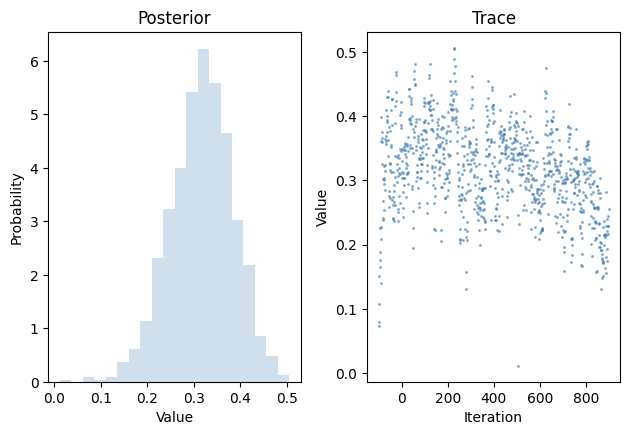

In [18]:
# Just for display purposes
# Visualize trace for the first taxa {visualization.py}
growth_trace_lf0_s0 = growth_lf0_s0.get_trace_from_disk(section='entire')
md2.visualization.render_trace(         # Visualizes the Trace of a random variable
    growth_trace_lf0_s0[:,0],     # Trace of the growth rates for the first taxa
    n_burnin=100                        # Tells how big the burnin array is
)
plt.show()

# Same as:
# # Just for display purposes
# # Visualize trace for the first taxa {visualization.py}
# glv_params_growth_trace_lf0_s0 = glv_params_growth_lf0_s0.get_trace_from_disk(section='entire')
# md2.visualization.render_trace(                 # Visualizes the Trace of a random variable
#     glv_params_growth_trace_lf0_s0[:,0],        # Trace of the growth rates for the first taxa
#     n_burnin=100                                # Tells how big the burnin array is
# )
# plt.show()

Self-interactions

In [21]:
# Get the trace of the self interactions {names.py, config.py, posterior.py}
self_interactions_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.SELF_INTERACTION_VALUE]

# Get the mean of the self interaction for each taxa {pylab/variables.py}
self_interactions_mean_lf0_s0 = md2.summary(self_interactions_lf0_s0)['mean']
for i in range(self_interactions_mean_lf0_s0.shape[0]):
    print(f'{mcnulty_lf0.taxa[i].name}: {self_interactions_mean_lf0_s0[i]}')

# Render the self interaction traces in the folder basepath. Makes a pandas.DataFrame table where the index is the Taxa name in taxa_formatter
self_interactions_lf0_s0_table = self_interactions_lf0_s0.visualize(
    self_interactions_s0_dir                                            # Loction to write the files to
)
self_interactions_lf0_s0_table.to_csv(self_interactions_s0_dir / 'self_interactions.tsv', sep='\t')
self_interactions_lf0_s0_table

# # Same as:
# # Get the trace of the generalized Lotka-Volterra parameters -> Self-interactions {names.py, config.py, posterior.py}
# glv_params_selfinter_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.GLV_PARAMETERS].self_interactions

# # Get the mean of the self-interactions coefficients for each taxa {pylab/variables.py}
# glv_params_selfinter_mean_lf0_s0 = md2.summary(glv_params_selfinter_lf0_s0)['mean']
# for i in range(glv_params_selfinter_mean_lf0_s0.shape[0]):
#     print(f'{mcnulty_lf0.taxa[i].name}: {glv_params_selfinter_mean_lf0_s0[i]}')

# # Render the self-interactions traces in the folder basepath. Makes a pandas.DataFrame table where the index is the Taxa name in taxa_formatter
# glv_params_selfinter_lf0_s0.visualize(
#     glv_params_s0                         # Loction to write the files to
# )

B_caccae: 4.769198328435541e-09
B_cellulosilyticus_WH2: 2.5635593296830652e-09
B_ovatus: 1.4420579628235235e-08
B_thetaiotaomicron: 1.4537028910959618e-08
B_uniformis: 1.7443824863485805e-08
B_vulgatus: 5.717725627198619e-09
C_aerofaciens: 2.1570801246787843e-07
C_scindens: 6.705459294859973e-08
C_spiroforme: 4.54379203409693e-07
D_longicatena: 1.8128165251524494e-06
P_distasonis: 2.2918263393066918e-08
R_obeum: 3.2297945035409254e-08


,name,median,mean,25th percentile,75th percentile
B_caccae,B_caccae,4.732197e-09,4.769198e-09,4.066022e-09,5.499349e-09
B_cellulosilyticus_WH2,B_cellulosilyticus_WH2,2.616953e-09,2.563559e-09,2.205537e-09,2.995456e-09
B_ovatus,B_ovatus,1.607830e-08,1.442058e-08,1.168960e-08,1.810652e-08
B_thetaiotaomicron,B_thetaiotaomicron,1.501163e-08,1.453703e-08,1.136262e-08,1.731662e-08
B_uniformis,B_uniformis,1.723349e-08,1.744382e-08,1.486343e-08,1.978651e-08
B_vulgatus,B_vulgatus,5.683306e-09,5.717726e-09,5.169625e-09,6.304414e-09
C_aerofaciens,C_aerofaciens,2.264249e-07,2.157080e-07,1.568049e-07,2.670834e-07
C_scindens,C_scindens,6.580852e-08,6.705459e-08,5.464751e-08,7.902501e-08
C_spiroforme,C_spiroforme,4.405413e-07,4.543792e-07,3.541241e-07,5.383798e-07
D_longicatena,D_longicatena,1.802078e-06,1.812817e-06,1.423189e-06,2.206827e-06


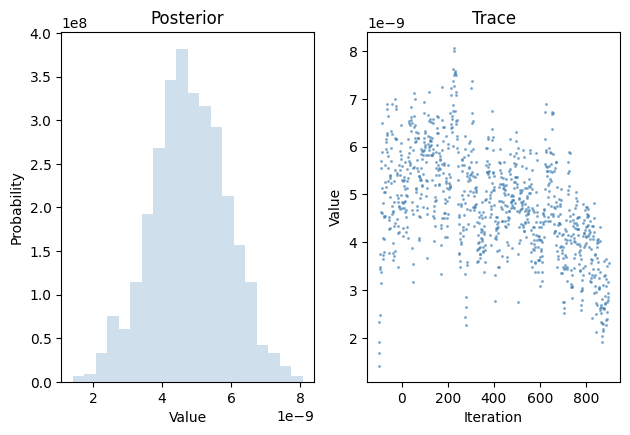

In [22]:
# Just for display purposes
# Visualize trace for the first taxa {visualization.py}
self_interactions_trace_lf0_s0 = self_interactions_lf0_s0.get_trace_from_disk(section='entire')
md2.visualization.render_trace(             # Visualizes the Trace of a random variable
    self_interactions_trace_lf0_s0[:,0],    # Trace of the self interactions rates for the first taxa
    n_burnin=100                            # Tells how big the burnin array is
)
plt.show()

# Same as:
# # Visualize trace for the first taxa {visualization.py}
# glv_params_selfinter_trace_lf0_s0 = glv_params_selfinter_lf0_s0.get_trace_from_disk(section='entire')
# md2.visualization.render_trace(                 # Visualizes the Trace of a random variable
#     glv_params_selfinter_trace_lf0_s0[:,0],     # Trace of the self-interaction coefficients for the first taxa
#     n_burnin=100                                # Tells how big the burnin array is
# )
# plt.show()

Process Variance

process variance mean: 0.21047288540592976


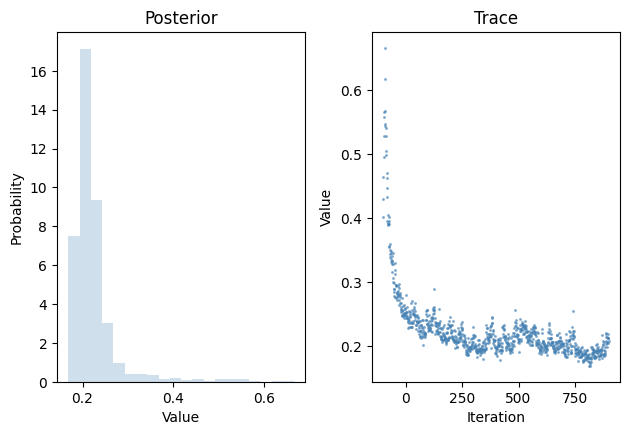

In [23]:
# Get the trace of the process variance {names.py, config.py, posterior.py}
procees_var_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.PROCESSVAR]
procees_var_trace_lf0_s0 = procees_var_lf0_s0.get_trace_from_disk(section='entire')

# Get the mean of the process variance {pylab/variables.py}
procees_var_mean_lf0_s0 = md2.summary(procees_var_lf0_s0)['mean']
print(f'process variance mean: {procees_var_mean_lf0_s0}')

# Visualize trace {visualization.py}
md2.visualization.render_trace(     # Visualizes the Trace of a random variable
    procees_var_trace_lf0_s0,       # Trace of the process variance
    n_burnin=100                    # Tells how big the burnin array is
)
plt.show()

Taxa module assignments

[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 3
[INFO] Clusters assigned: [0 1 1 0 0 0 0 0 0 2 1 1]


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


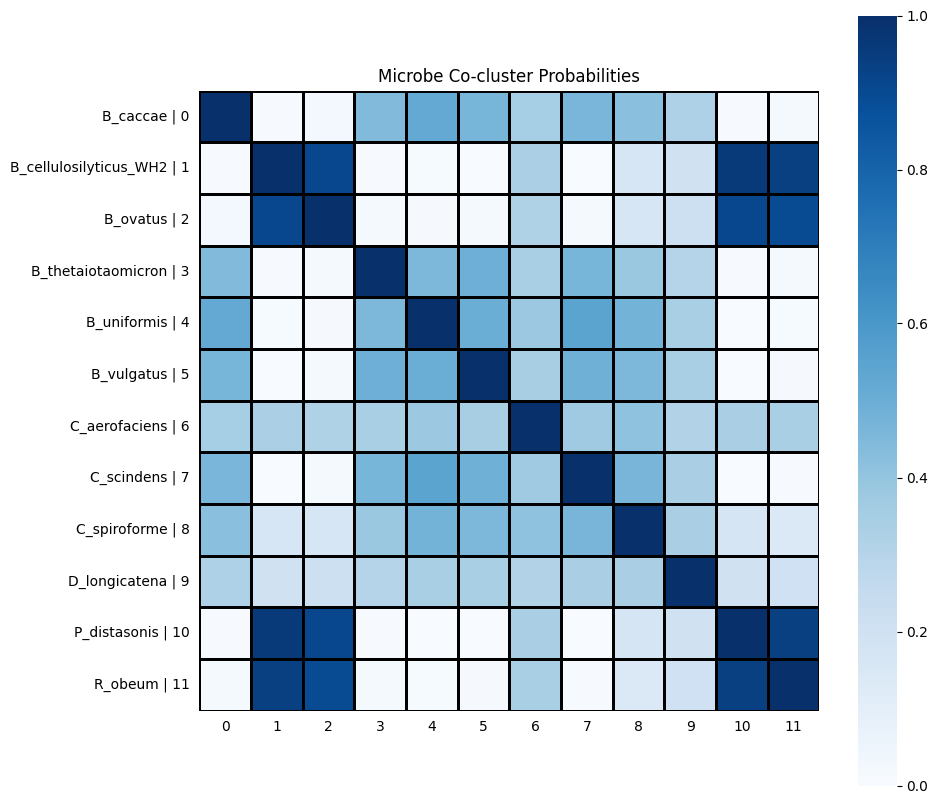

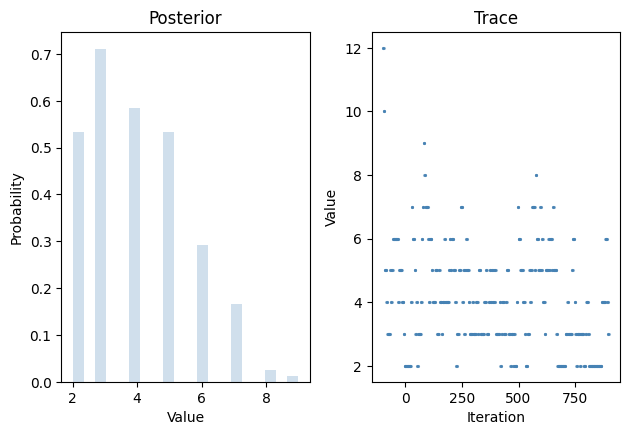

array([[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [25]:
# Get the clustering assignments and probabilities  {names.py, posterior.py, pylab/cluster.py}
clustering_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.CLUSTERING_OBJ]
# Once the inference is complete, compute the clusters posthoc using sklearn's AgglomerativeClustering function with distance matrix being 1 - cocluster matrix {util.py}
md2.generate_cluster_assignments_posthoc(       # Returns np.ndarray(size=(len(items), ), dtype=int)
    clustering_lf0_s0,                          # Clustering object (mdsine2.posterior.Clustering)
    # n_clusters=12,                            # This specifies the number of clusters that are used during Agglomerative clustering.
    set_as_value=True                           # If True then set the result as the value of the clustering object
)

# Get the taxa from the graph
taxa = mcmc_lf0_s0.graph.data.taxa

# Visualize co-cluster posterior probability {posterior.py, visualization.py}
coclusters_lf0_s0 = md2.summary(mcmc_lf0_s0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']  # Get the mean of the cocluster posterior
md2.visualization.render_cocluster_probabilities(   # Render the cocluster proportions. Values in coclusters should be [0,1]
    coclusters_lf0_s0, taxa=mcnulty_lf0.taxa,       # Square matrix indicating the cocluster proportions (2-dim np.ndarray)
    yticklabels='%(name)s | %(index)s')             # Label for the y-axis (str)

# Visualize trace for number of modules
md2.visualization.render_trace(         # Visualizes the Trace of a random variable
    clustering_lf0_s0.n_clusters        # Trace of the co-clustering probabilities
)
plt.show()
clustering_lf0_s0.generate_coclusters()

Module interctions

In [123]:
# Not sure about these results
# interactions_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.INTERACTIONS_OBJ]
# interactions_lf0_s0.get_value_matrix()
# interactions_lf0_s0.get_values()

In [26]:
# Get Lotka-Volterra interactions {names.py, config.py, posterior.py}
interactions_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.CLUSTER_INTERACTION_VALUE]
# Same as glv_params_interactions_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.GLV_PARAMETERS].interactions
interactions_lf0_s0.visualize(interactions_s0_dir)
interactions_lf0_s0_matrix = pd.read_table(f'{interactions_s0_dir}/mean_matrix.tsv', index_col=0)
interactions_lf0_s0_matrix

[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 3
[INFO] Clusters assigned: [0 1 1 0 0 0 0 0 0 2 1 1]


,B_caccae,B_thetaiotaomicron,B_uniformis,B_vulgatus,C_aerofaciens,C_scindens,C_spiroforme,B_cellulosilyticus_WH2,B_ovatus,P_distasonis,R_obeum,D_longicatena
B_caccae,0.000000e+00,0.000000e+00,2.936553e-12,-1.435538e-12,2.727719e-11,0.000000e+00,-7.789716e-10,-5.138767e-13,-5.138767e-13,-5.138767e-13,-5.138767e-13,8.923895e-09
B_thetaiotaomicron,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.203108e-11,1.363301e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.437804e-08
B_uniformis,0.000000e+00,0.000000e+00,0.000000e+00,-1.435538e-12,-4.829694e-11,0.000000e+00,-5.771243e-11,-5.138767e-13,-5.138767e-13,-5.138767e-13,-5.138767e-13,1.013116e-08
B_vulgatus,8.425460e-13,8.425460e-13,2.106942e-11,0.000000e+00,-3.168485e-13,-9.853708e-12,8.425460e-13,4.477706e-13,4.477706e-13,4.477706e-13,4.477706e-13,1.183063e-08
C_aerofaciens,6.376417e-11,-5.651543e-12,1.032498e-10,4.573031e-12,0.000000e+00,6.073246e-11,5.797995e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.687905e-08
C_scindens,8.425460e-13,8.425460e-13,0.000000e+00,0.000000e+00,-3.690458e-11,0.000000e+00,-2.946607e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.573490e-09
C_spiroforme,2.500786e-11,7.495368e-12,9.023017e-11,8.777738e-12,3.976129e-11,7.167222e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.049869e-08
B_cellulosilyticus_WH2,2.138328e-10,-1.970634e-11,3.868125e-10,1.738539e-11,-9.719131e-11,4.281540e-10,3.728406e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.749538e-08
B_ovatus,2.392164e-10,-1.970634e-11,3.936933e-10,2.426619e-11,-9.719131e-11,4.395081e-10,1.821182e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.022985e-08
P_distasonis,2.138328e-10,-1.970634e-11,3.868125e-10,1.738539e-11,-9.719131e-11,5.714983e-10,1.821182e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.830567e-08


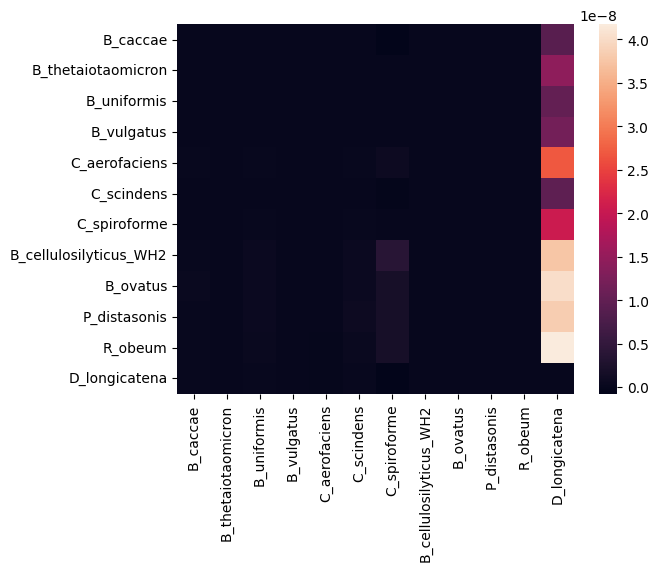

In [27]:
# sns.heatmap(np.log10(np.abs(interactions_lf0_s0_matrix)))
sns.heatmap(interactions_lf0_s0_matrix)
plt.show()

In [28]:
interactions_lf0_s0_table = interactions_lf0_s0_matrix.reset_index()
interactions_lf0_s0_table.rename(columns={'index': 'Source'}, inplace=True)
names = [taxa[i].name for i in interactions_lf0_s0_table['Source']]
interactions_lf0_s0_table = interactions_lf0_s0_table.melt(id_vars=['Source'], var_name='Target', value_name='Interaction_coefficient')
def interaction_type(x):
    if x > 0:
        return '+'
    elif x < 0:
        return '-'
    else:
        return np.nan
interactions_lf0_s0_table['Interaction_magnitude_log'] = np.log10(np.abs(interactions_lf0_s0_table['Interaction_coefficient']))
interactions_lf0_s0_table['Interaction'] = interactions_lf0_s0_table['Interaction_coefficient'].apply(interaction_type)
interactions_lf0_s0_table.dropna(inplace=True)
interactions_lf0_s0_table = interactions_lf0_s0_table.loc[:, ['Source', 'Target', 'Interaction', 'Interaction_magnitude_log']].copy()
interactions_lf0_s0_table.set_index(['Source', 'Target'], inplace=True)
interactions_lf0_s0_table.to_csv(f'{interactions_s0_dir}/interaction_network.tsv', sep='\t')
interactions_lf0_s0_table

,,Interaction,Interaction_magnitude_log
Source,Target,,
B_vulgatus,B_caccae,+,-12.074406
C_aerofaciens,B_caccae,+,-10.195423
C_scindens,B_caccae,+,-12.074406
C_spiroforme,B_caccae,+,-10.601923
B_cellulosilyticus_WH2,B_caccae,+,-9.669926
...,...,...,...
C_spiroforme,D_longicatena,+,-7.688274
B_cellulosilyticus_WH2,D_longicatena,+,-7.426022
B_ovatus,D_longicatena,+,-7.395452


In [29]:
md2.generate_interation_bayes_factors_posthoc(mcmc_lf0_s0)

array([[0.        , 0.00892996, 0.00892996, 0.        , 0.00892996,
        0.00892996, 0.00892996, 0.        , 0.0268496 , 0.20115797,
        0.00892996, 0.00892996],
       [1.52914889, 0.        , 0.        , 0.50234437, 1.6963674 ,
        0.34419139, 0.60426045, 1.08322748, 0.88100471, 1.1526907 ,
        0.        , 0.        ],
       [1.61846834, 0.        , 0.        , 0.50234437, 1.70947306,
        0.35390395, 0.60426045, 1.1178272 , 0.81557727, 1.16437101,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00892996, 0.00892996, 0.        , 0.21994607,
        0.        , 0.        ],
       [0.        , 0.00892996, 0.00892996, 0.        , 0.        ,
        0.00892996, 0.0268496 , 0.        , 0.00892996, 0.24828964,
        0.00892996, 0.00892996],
       [0.0178798 , 0.00892996, 0.00892996, 0.0178798 , 0.03583943,
        0.        , 0.0268496 , 0.00892996, 0.0178798 , 0.18245527,
        0.00892996,

Perturbation effect

In [30]:
glv_params_pert_mag_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.GLV_PARAMETERS].pert_mag
# Same as:
# perturbations_magnitude_lf0_s0 = mcmc_lf0_s0.graph[STRNAMES.PERT_VALUE]
glv_params_pert_mag_lf0_s0.asarray()

array([32.6671729 , 12.29401988])

In [31]:
glv_params_pert_mag_lf0_s0.visualize(perturbation_s0_dir, 0)
pd.read_table(f'{perturbation_s0_dir}/values.tsv', index_col=0)

[INFO] `ax.hist` failed: autodetected range of [nan, nan] is not finite
[INFO] `ax.hist` failed: autodetected range of [nan, nan] is not finite


,median,mean,25th percentile,75th percentile
B_caccae,0.000000,0.001622,0.000000,0.000000
B_cellulosilyticus_WH2,-0.844525,-0.852325,-0.925875,-0.782282
B_ovatus,-0.850280,-0.975690,-0.941428,-0.789139
B_thetaiotaomicron,0.000000,0.000000,0.000000,0.000000
B_uniformis,0.000000,0.000985,0.000000,0.000000
B_vulgatus,0.000000,0.000000,0.000000,0.000000
C_aerofaciens,0.000000,-0.293807,-0.756523,0.000000
C_scindens,0.000000,0.000187,0.000000,0.000000
C_spiroforme,0.000000,-0.140646,0.000000,0.000000
D_longicatena,0.000000,5.222292,0.000000,0.000000


**IMPORTANT:** All model parameters have traces and can be visualized in a similar fashion. All `STRNAMES` can be found in names.py. Also check posterior.py

### Run inference on the full model again, but with a different seed (seed=1)

In [34]:
# Set directory
basepath_s1 = output_dir / "mdsine2" / "seed1"
basepath_s1.mkdir(exist_ok=True, parents=True)

# Initialize parameters of the model
params_lf0_s1 = md2.config.MDSINE2ModelConfig(
    basepath=str(basepath_s1),            
    seed=1,                            
    burnin=100,                        
    n_samples=1000,                    
    negbin_a0=a0_lf0, negbin_a1=a1_lf0,
    checkpoint=100                     
)

# Initialize the clustering choice
params_lf0_s1.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

# Builds the graph with the posterior classes and creates an mdsine2.BaseMCMC inference chain object that you ran run inference with
mcmc_lf0_s1 = md2.initialize_graph(
    params=params_lf0_s1,          
    graph_name=mcnulty_lf0.name,   
    subjset=mcnulty_lf0            
)

# Perform inference
mcmc_lf0_s1 = md2.run_graph(
    mcmc_lf0_s1,            
    crash_if_error=True     
)

[INFO] max_value found: 1304402561.1345034, scaling_factor: 7.666344959720491e-08
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 7.6663E-08
[INFO] There are 168 qPCR measurements for 3 buckets. Each bucket is 56 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.  1.  2.  4.  6.  9. 11. 12. 14. 15. 16. 18. 20. 24. 25. 26. 28. 29.
 30. 32. 34. 37. 39. 40.]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 12
Cluster 100112
	members: ['B_caccae']
	size: 1
Cluster 100113
	members: ['B_cellulosilyticus_WH2']
	size: 1
Cluster 100114
	members: ['B_ovatus']
	size: 1
Cluster 100115
	members: ['B_thetaiotaomicron']
	size: 1
Cluster 100116
	members: ['B_uniformis']
	size: 1
Cluster 100117
	members: ['B_vulgatus']
	size: 1
Cluster 100118
	members: ['C_aerofaciens']
	size: 1
Cluster 100119
	members: ['C_scindens']
	size: 1
Cluster 100120
	members: ['C_spiroforme']
	size: 1
Cluster 100121
	members: ['D_longicatena']
	size: 1
Cluster 100122
	mem

### Visualize posteriors

B_caccae: 0.3064069642943009
B_cellulosilyticus_WH2: 0.4614540630090185
B_ovatus: 0.7281752488200165
B_thetaiotaomicron: 0.5363291387020311
B_uniformis: 0.3615221024828251
B_vulgatus: 0.2859647237524166
C_aerofaciens: 0.45866200820146535
C_scindens: 0.4775221924304963
C_spiroforme: 0.15838995212381976
D_longicatena: 0.035906488407996526
P_distasonis: 0.47185875913730224
R_obeum: 0.8034192364426959


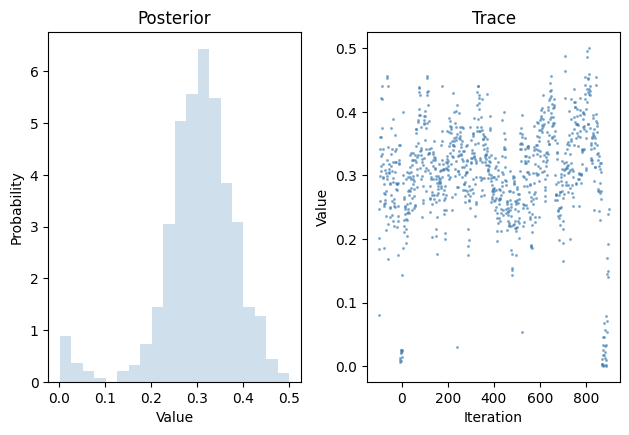

[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 3
[INFO] Clusters assigned: [0 1 1 0 0 0 1 0 0 2 1 1]


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


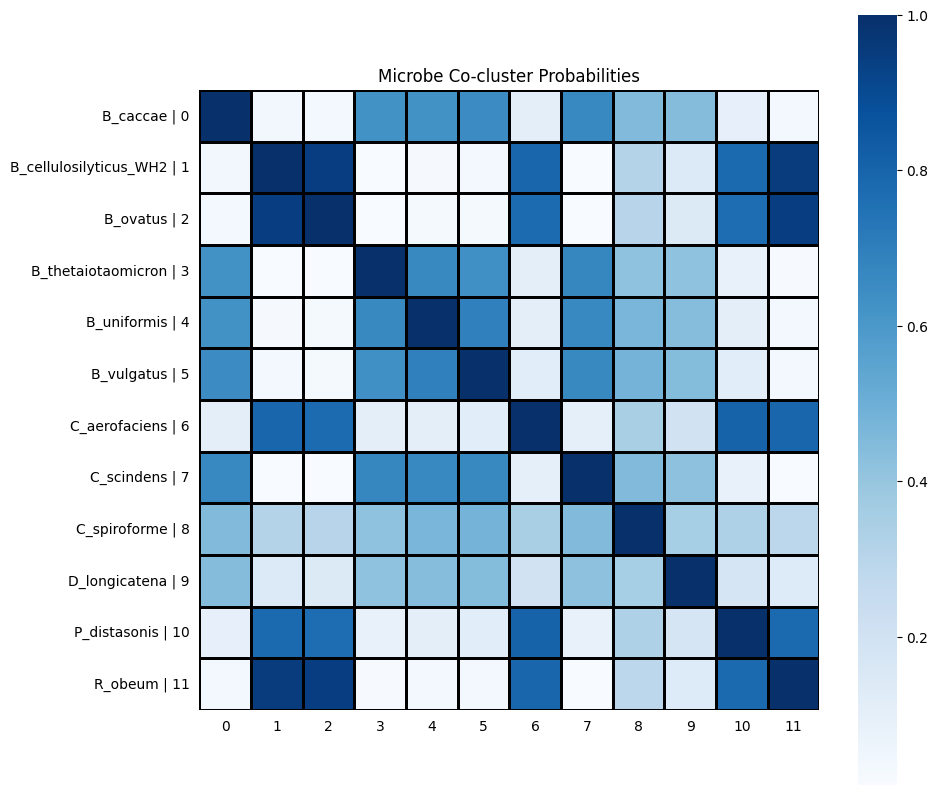

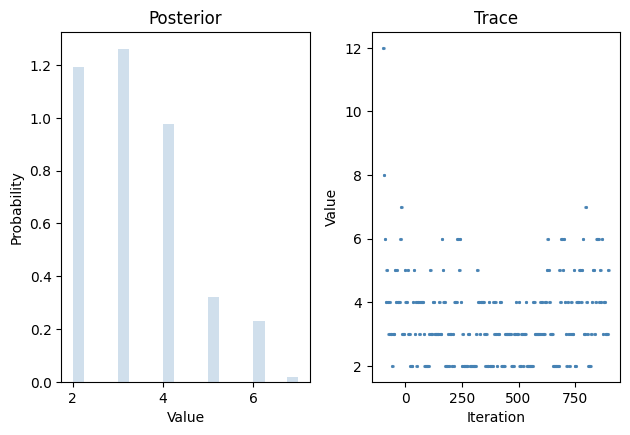

In [71]:
# Get the trace of the growth rates
growth_lf0_s1 = mcmc_lf0_s1.graph[STRNAMES.GROWTH_VALUE]
growth_rates_trace_lf0_s1 = growth_lf0_s1.get_trace_from_disk(section='entire')

# Get the mean of the growth rates for each taxa
growth_rates_mean_lf0_s1 = md2.summary(growth_lf0_s1)['mean']
for i in range(growth_rates_mean_lf0_s1.shape[0]):
    print(f'{mcnulty_lf0.taxa[i].name}: {growth_rates_mean_lf0_s1[i]}')

# Visualize trace for the first taxa
md2.visualization.render_trace(
    growth_rates_trace_lf0_s1[:,0],
    n_burnin=100
)
plt.show()

# Get the clustering assignments and probabilities 
clustering_lf0_s1 = mcmc_lf0_s1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(       
    clustering_lf0_s1,                         
    # n_clusters=2,                             
    set_as_value=True                           
)

# Get the taxa from the graph
taxa = mcmc_lf0_s1.graph.data.taxa 

# Visualize co-cluster posterior probability 
coclusters_lf0_s1 = md2.summary(mcmc_lf0_s1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean'] 
md2.visualization.render_cocluster_probabilities(   
    coclusters_lf0_s1, taxa=mcnulty_lf0.taxa,    
    yticklabels='%(name)s | %(index)s')           

# Visualize trace for number of modules
md2.visualization.render_trace(        
    clustering_lf0_s1.n_clusters       
)
plt.show()

## Compute [$\hat{r}$](https://www-jstor-org.ezproxy.uniandes.edu.co/stable/pdf/2246093.pdf?ab_segments=) statistic on model parameters to assess mixing

In [36]:
# Calculate the rhat statistic- It assesses mixing of the chains {pylab/inference.py}
chains_lf0 = [mcmc_lf0_s0, mcmc_lf0_s1]
start = 0
end = 1000

rhat_growth_rates_lf0 = md2.pylab.inference.r_hat(          # Computes the rhat for a variable in the chain
    chains_lf0,                                             # An iterable object of pylab.inference.BaseMCMC objects
    start=start,                                            # The start index of the chain to compute the rhat
    end=end,                                                # The end index of the chain to compute the rhat
    vname=STRNAMES.GROWTH_VALUE                             # The name of the variable to compute the rhat
)
print('Growth parameter r-hat:', rhat_growth_rates_lf0)

rhat_concentration_lf0 = md2.pylab.inference.r_hat(         # Computes the rhat for a variable in the chain
    chains_lf0,                                             # An iterable object of pylab.inference.BaseMCMC objects
    start=start,                                            # The start index of the chain to compute the rhat
    end=end,                                                # The end index of the chain to compute the rhat
    vname=STRNAMES.CONCENTRATION                            # The name of the variable to compute the rhat
)
print('Concentration parameter r-hat:', rhat_concentration_lf0)

rhat_processvar_lf0 = md2.pylab.inference.r_hat(            # Computes the rhat for a variable in the chain
    chains_lf0,                                             # An iterable object of pylab.inference.BaseMCMC objects
    start=start,                                            # The start index of the chain to compute the rhat
    end=end,                                                # The end index of the chain to compute the rhat
    vname=STRNAMES.PROCESSVAR                               # The name of the variable to compute the rhat
)
print('Process variance parameter r-hat:', rhat_processvar_lf0)

Growth parameter r-hat: [1.0212373  1.01157054 1.02306567 1.30124787 1.02791404 2.36144557
 1.01072612 1.05898625 1.00455757 1.01412274 1.06788358 1.17629406]
Concentration parameter r-hat: [2.89776886]
Process variance parameter r-hat: [9.31605177]


In [62]:
def shrink_factor(chains, window, vname):
    r_hat_window = []
    for i in range(np.around(chains[0].n_samples/window).astype(int)):
        r_hat_window.append(md2.pylab.inference.r_hat(chains, start=i, end=i+window, vname=vname))
    return np.array(r_hat_window)
    

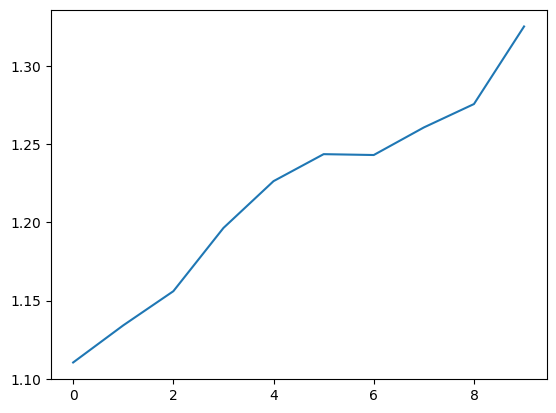

In [69]:
plt.plot(shrink_factor(chains_lf0, 100, STRNAMES.GROWTH_VALUE)[:,0])
plt.show()


## Consensus clustering

Run the model with module assignments fixed (to their most likely module assignment learned from the previous step)

In [31]:
# Set directory
basepath_mxcl = output_dir / 'mdsine2-fixed-cluster'
basepath_mxcl.mkdir(exist_ok=True)

Use the clustering from a previous as the clustering assignment

In [32]:
# Initialize parameters of the model
params_mxcl_lf0 = md2.config.MDSINE2ModelConfig(
    basepath=basepath_mxcl, 
    seed=0, 
    burnin=100, 
    n_samples=1000, 
    negbin_a0=a0_lf0, negbin_a1=a1_lf0, 
    checkpoint=100
)

# Do not learn the clustering parameters
params_mxcl_lf0.LEARN[STRNAMES.CLUSTERING] = False
params_mxcl_lf0.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering (the ones that were already learned)
params_mxcl_lf0.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params_mxcl_lf0.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = str(basepath_s0 / "mcmc.pkl") # Most likely module assignment

# Initialize the graph
mcmc_mxcl_lf0 = md2.initialize_graph(
    params=params_mxcl_lf0, 
    graph_name=mcnulty_lf0.name, 
    subjset=mcnulty_lf0
)
# Run inference
mcmc_mxcl_lf0 = md2.run_graph(
    mcmc_mxcl_lf0, 
    crash_if_error=True
)

[INFO] max_value found: 1304402561.1345034, scaling_factor: 7.666344959720491e-08
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 7.6663E-08
[INFO] There are 168 qPCR measurements for 3 buckets. Each bucket is 56 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.  1.  2.  4.  6.  9. 11. 12. 14. 15. 16. 18. 20. 24. 25. 26. 28. 29.
 30. 32. 34. 37. 39. 40.]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Fixed topology initialization


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 3
[INFO] Clusters assigned: [0 1 1 0 0 0 0 0 0 2 1 1]
[INFO] Clustering set to:
Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 103112
	members: ['B_caccae', 'B_thetaiotaomicron', 'B_uniformis', 'B_vulgatus', 'C_aerofaciens', 'C_scindens', 'C_spiroforme']
	size: 7
Cluster 103113
	members: ['R_obeum', 'B_cellulosilyticus_WH2', 'B_ovatus', 'P_distasonis']
	size: 4
Cluster 103114
	members: ['D_longicatena']
	size: 1
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100112
	members: ['B_caccae', 'B_thetaiotaomicron', 'B_uniformis', 'B_vulgatus', 'C_aerofaciens', 'C_scindens', 'C_spiroforme']
	size: 7
Cluster 100113
	members: ['P_distasonis', 'B_cellulosilyticus_WH2', 'B_ovatus', 'R_obeum']
	size: 4
Cluster 100114
	members: ['D_longicatena']
	size: 1
[INFO] Initializing Process Variance parameter
[INFO] Initializing Mean para

[WARNING] Automatically setting xlabels as index because there are no taxa


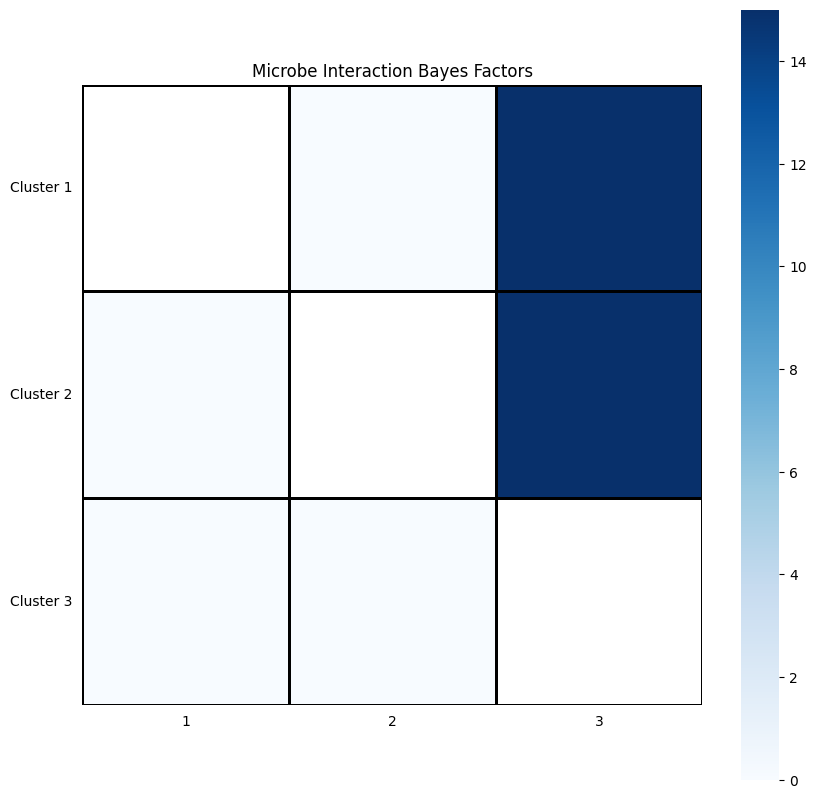

In [33]:
# Plot bayes factors for module-module interactions
clustering_mxcl_lf0 = mcmc_mxcl_lf0.graph[STRNAMES.CLUSTERING_OBJ]
# Generates the bayes factors on an item-item level for the interactions, given the passed in prior {util.py}
bf_taxa_mxcl_lf0 = md2.generate_interation_bayes_factors_posthoc(   # Return bayes factors for each of the interactions on an item-item level [np.ndarray((n,n), dtype=float)]
    mcmc_mxcl_lf0                                                   # This is the inference object containing the traces (mdsine2.BaseMCMC)
)
# Condense the interaction matrix M with the cluster assignments in clustering. Assume that the current cluster assignments is what is used {util.py}
bf_clustering_mxcl_lf0 = md2.condense_fixed_clustering_interaction_matrix(  # Return cluster-cluster interaction matrix [np.ndarray((…, n_clusters, n_clusters)]
    bf_taxa_mxcl_lf0,                                                       # Taxon-taxon interaction matrix [np.ndarray((…, n_taxa, n_taxa), dtype=float)]
    clustering=clustering_mxcl_lf0                                          # Clustering object (mdsine2.Clustering)
)

# Visualize the bayes factors
labels = ['Cluster {}'.format(i+1, i+1) for i in range(len(clustering_mxcl_lf0))]
md2.visualization.render_bayes_factors(     # Renders the bayes factors for each of the interactions
    bf_clustering_mxcl_lf0,                 # Square matrix indicating the bayes factors of the interaction (2-dim np.ndarray)
    yticklabels=labels                      # Labels for the y-axis (list of str)
)
plt.show()

## Cross validation Example

Take out a single subject, perform inference on the rest, and then forward simulate from initial condition of held out subject

In [34]:
# Make the data and validation Study objects
mcnulty_lf0_holdout = md2.dataset.parse(             
    name='mcnulty_lf0_holdout',                       
    metadata=str(input_dir / 'metadata.tsv'),         
    taxonomy=str(input_dir / 'taxonomy.tsv'),         
    reads=str(input_dir / 'reads.tsv'),                
    qpcr=str(input_dir / 'dna_yields.tsv'),            
    perturbations=str(input_dir / 'perturbations.tsv'),
    sep='\t'                                           
)

# Remove one subject -> Subject '1' {base/study.py}
mcnulty_lf0_validate = mcnulty_lf0_holdout.pop_subject('1')
mcnulty_lf0_validate.name = 'mcnulty_lf0_validate'

[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations


In [35]:
# Inspect each object
print(mcnulty_lf0_holdout.name)
for subj in mcnulty_lf0_holdout:
    print(subj.name)
for pert in mcnulty_lf0_holdout.perturbations:
    print(pert)
print()
print(mcnulty_lf0_validate.name)
for subj in mcnulty_lf0_validate:
    print(subj.name)
for pert in mcnulty_lf0_validate.perturbations:
    print(pert)

mcnulty_lf0_holdout
2
3
4
5
6
7
Perturbation HF/HS:
	Subject 2: (14, 26)
	Subject 3: (14, 26)
	Subject 4: (14, 26)
	Subject 5: (14, 26)
	Subject 6: (14, 26)
	Subject 7: (14, 26)


mcnulty_lf0_validate
1
Perturbation HF/HS:
	Subject 1: (14, 26)



In [36]:
# Set output directory
cv_output_dir = output_dir / "cv"

In [37]:
# Learn the model (perform the inference)
# Initialize parameters of the model
params_lf0_cv = md2.config.MDSINE2ModelConfig(
    basepath=cv_output_dir / mcnulty_lf0_holdout.name,            
    seed=0,                            
    burnin=100,                        
    n_samples=1000,                    
    negbin_a0=a0_lf0, negbin_a1=a1_lf0,
    checkpoint=100                     
)

# Initialize the clustering choice
params_lf0_cv.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

# Builds the graph with the posterior classes and creates an mdsine2.BaseMCMC inference chain object that you ran run inference with
mcmc_lf0_cv = md2.initialize_graph(
    params=params_lf0_cv,          
    graph_name=mcnulty_lf0_holdout.name,   
    subjset=mcnulty_lf0_holdout          
)

# Perform inference
mcmc_lf0_cv = md2.run_graph(
    mcmc_lf0_cv,            
    crash_if_error=True     
)

[INFO] max_value found: 1304402561.1345034, scaling_factor: 7.666344959720491e-08
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 7.6663E-08
[INFO] There are 144 qPCR measurements for 3 buckets. Each bucket is 48 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.  1.  2.  4.  6.  9. 11. 12. 14. 15. 16. 18. 20. 24. 25. 26. 28. 29.
 30. 32. 34. 37. 39. 40.]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 12
Cluster 100112
	members: ['B_caccae']
	size: 1
Cluster 100113
	members: ['B_cellulosilyticus_WH2']
	size: 1
Cluster 100114
	members: ['B_ovatus']
	size: 1
Cluster 100115
	members: ['B_thetaiotaomicron']
	size: 1
Cluster 100116
	members: ['B_uniformis']
	size: 1
Cluster 100117
	members: ['B_vulgatus']
	size: 1
Cluster 100118
	members: ['C_aerofaciens']
	size: 1
Cluster 100119
	members: ['C_scindens']
	size: 1
Cluster 100120
	members: ['C_spiroforme']
	size: 1
Cluster 100121
	members: ['D_longicatena']
	size: 1
Cluster 100122
	mem

### Forward simulate

In [38]:
# Define Subject
subj_val = mcnulty_lf0_validate['1']
# Make a numpy matrix out of our data - returns the raw reads, the relative abundance, and the absolute abundance {base/subject.py}
M_truth_val = subj_val.matrix()['abs']          # Returns Dict[str, np.ndarray]
print('Absolute abundance true value matrix shape for subject 1: ', M_truth_val.shape)
# Get initial conditions
initial_conditions_val = M_truth_val[:,0]
times_val = subj_val.times
print('Initial conditions (Absolute abundace for each species): ', initial_conditions_val)
print('Times: ', times_val)

Absolute abundance true value matrix shape for subject 1:  (12, 24)
Initial conditions (Absolute abundace for each species):  [5.26766483e+06 7.06224082e+06 8.60548011e+06 3.32260701e+06
 8.18845331e+05 6.97275215e+07 6.48352608e+04 3.67800029e+06
 2.56139302e+04 2.20119713e+05 1.03256156e+05 2.95360633e+05]
Times:  [ 0.  1.  2.  4.  6.  9. 11. 12. 14. 15. 16. 18. 20. 24. 25. 26. 28. 29.
 30. 32. 34. 37. 39. 40.]


In [39]:
# Forward simulate for each gibb step. Forward simulate the dynamics from a chain. This assumes that the initial conditions occur at time times[0] {model.py}
# class gLVDynamicsSingleClustering -> Discretized Generalized Lotka-Voltera Dynamics with clustered interactions and perturbations.
M_val = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(   # returns np.ndarray(n_gibbs, n_taxa, len(times))
    mcmc_lf0_cv,                                                        # MCMC chain with all of the traces of the parameters (mdsine2.BaseMCMC)     
    subj=subj_val,                                                      # This is the subject we are forward simulating for. Start and end times for each perturbation needed (mdsine2.Subject)    
    initial_conditions=initial_conditions_val,                          # Initial conditions for each taxon {np.ndarray(n_taxa)}
    times=times_val,                                                    # Times for the forward simulation {np.ndarray(n_times)}
    simulation_dt=0.01                                                  # Time step for the forward simulation {float}
)

[INFO] 5/900 - 0.22157692909240723
[INFO] 10/900 - 0.25766515731811523
[INFO] 15/900 - 0.2420957088470459
[INFO] 20/900 - 0.23392939567565918
[INFO] 25/900 - 0.21713495254516602
[INFO] 30/900 - 0.2197873592376709
[INFO] 35/900 - 0.21898436546325684
[INFO] 40/900 - 0.21155834197998047
[INFO] 45/900 - 0.21626496315002441
[INFO] 50/900 - 0.21686840057373047
[INFO] 55/900 - 0.25667285919189453
[INFO] 60/900 - 0.21353673934936523
[INFO] 65/900 - 0.22603321075439453
[INFO] 70/900 - 0.2175915241241455
[INFO] 75/900 - 0.22096872329711914
[INFO] 80/900 - 0.22039127349853516
[INFO] 85/900 - 0.21497559547424316
[INFO] 90/900 - 0.2136247158050537
[INFO] 95/900 - 0.21242237091064453
[INFO] 100/900 - 0.22220587730407715
[INFO] 105/900 - 0.24537420272827148
[INFO] 110/900 - 0.2670624256134033
[INFO] 115/900 - 0.2138357162475586
[INFO] 120/900 - 0.2359633445739746
[INFO] 125/900 - 0.2119152545928955
[INFO] 130/900 - 0.2118840217590332
[INFO] 135/900 - 0.22113370895385742
[INFO] 140/900 - 0.21604681015

Plot the forward sims, 5th-95th percentile

In [40]:
# Define the taxas
taxa_val = subj_val.taxa
# Define percentiles
low_val = np.percentile(M_val, q=5, axis=0)
med_val = np.percentile(M_val, q=50, axis=0)
high_val = np.percentile(M_val, q=95, axis=0)

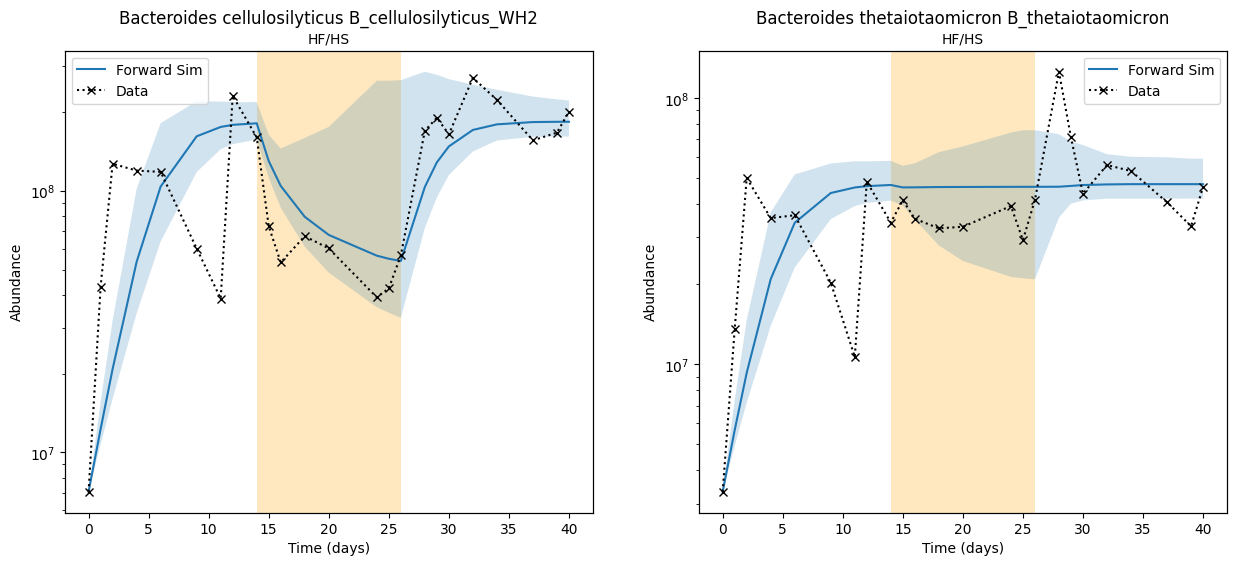

In [41]:
oidxs = [1,3]
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for i, oidx in enumerate(oidxs):
    ax = axs[i]
    ax.fill_between(times_val, y1=low_val[oidx, :], y2=high_val[oidx, :], alpha=0.2)
    ax.plot(times_val, med_val[oidx,:], label='Forward Sim')
    ax.plot(times_val, M_truth_val[oidx, :], label='Data', marker='x', color='black',
           linestyle=':')
    ax.set_yscale('log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Abundance')
    ax.set_title(md2.taxaname_for_paper(taxa[oidx], taxa))
    md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
    ax.legend()
plt.show()

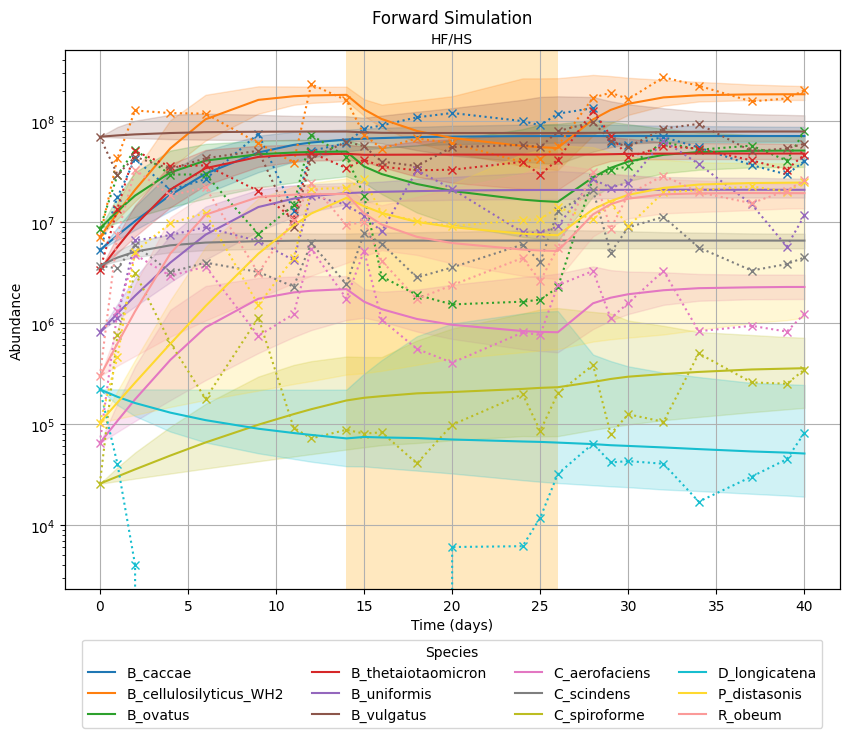

In [42]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
col = 0
for i in range(len(subj_val.taxa)):
    ax.fill_between(times_val, y1=low_val[i, :], y2=high_val[i, :], alpha=0.2, color=cols[col])
    ax.plot(times_val, med_val[i,:], label=f'{taxa_val[i].name}', color=cols[col])
    ax.plot(times_val, M_truth_val[i, :], marker='x',linestyle=':', color=cols[col])
    col+=1
ax.set_yscale('log')
ax.set_title('Forward Simulation')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Abundance')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.27), ncol=4, fancybox=True, shadow=False, title='Species')
ax.grid()
md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
# ax.set_ylim(bottom=1e5, top=1e12)
plt.show()